# MODERN PORTFOLIO MANAGEMENT
In this notebook, I present a short example which constructs the [efficient frontier](https://en.wikipedia.org/wiki/Efficient_frontier#:~:text=Efficient%20Frontier.,line%20is%20the%20efficient%20frontier.)
This maps out the minimum variance porfolios for a desired return.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from findatapy.market import Market, MarketDataGenerator, MarketDataRequest

First, I download the market data from yahoo finance using `findatapy`. 
I download an assortment of stocks from different industries to make sure the correlation matrix has a range of off-diagonal elements.
The last ten years of closing values are used. This does not include the 2008 crash but does include the period of the COVID-19 pandemic.

In [15]:
market = Market(market_data_generator=MarketDataGenerator())

# In the config file, we can use keywords 'open', 'high', 'low', 'close'
# and 'volume' for Yahoo and Google finance data

# Download equities data from Yahoo
md_request = MarketDataRequest(
    start_date="decade",  # start date
    data_source='yahoo',  # use Bloomberg as data source
    tickers=['Apple', 'Tesla', 'Google', 'Walmart','Citigroup', 'Ford', 'Gold', 'GameStop', 'Disney', 'coke'],  # ticker (findatapy)
#     fields=['close'],  # which fields to download
    vendor_tickers=['aapl', 'tsla', 'goog', 'wmt','c','f', 'gold', 'gme', 'dis', 'coke'],  # ticker (Yahoo)
    vendor_fields=['Close'])  # which Bloomberg fields to download)

df = market.fetch_market(md_request)
df

2022-07-05 10:22:31,911 - findatapy.market.datavendorweb - INFO - Request Yahoo data
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
2022-07-05 10:22:33,222 - findatapy.market.datavendorweb - INFO - Completed request from Yahoo.
2022-07-05 10:22:33,289 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_964__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__category-None__category_key-backtest_default-cat_yahoo_daily_NYC__cut-NYC__data_engine-None__data_source-yahoo__environment-backtest__expiry_date-NaT__fields-close__finish_date-2022-07-05 17:12:19_671275__freeform_md_request-{}__freq-daily__freq_mult-1__fx_forwards_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__fx_vol_part-V_25R_10R_25B_10B__fx_vol_tenor-ON_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__gran_freq-None

Apple.close  Tesla.close  Google.close  Walmart.close  \
Date                                                                
2012-07-09    21.924643     6.298000    291.910858      71.760002   
2012-07-10    21.721786     6.254000    289.763885      72.110001   
2012-07-11    21.586786     6.302000    284.528503      72.260002   
2012-07-12    21.389286     6.540000    284.174835      72.309998   
2012-07-13    21.606071     6.850000    287.183563      73.180000   
...                 ...          ...           ...            ...   
2022-06-28   137.440002   697.989990   2251.429932     122.370003   
2022-06-29   139.229996   685.469971   2245.129883     121.919998   
2022-06-30   136.720001   673.419983   2187.449951     121.580002   
2022-07-01   138.929993   681.789978   2181.620117     122.629997   
2022-07-05   139.759995   685.749207   2237.000000     123.720001   

            Citigroup.close  Ford.close  Gold.close  GameStop.close  \
Date                                                                  
2012-07-09        26.110001        9.45   36.630001       17.520000   
2012-07-10        25.879999        9.35   35.630001       17.549999   
2012-07-11        25.870001        9.33   34.950001       17.209999   
2012-07-12        25.280001        9.13   34.560001       17.100000   
2012-07-13        26.650000        9.27   34.840000       16.830000   
...                     ...         ...         ...             ...   
2022-06-28        47.209999       11.81   18.549999      124.379997   
2022-06-29        47.099998       11.52   18.389999      122.860001   
2022-06-30        45.990002       11.13   17.690001      122.300003   
2022-07-01        46.869999       11.32   18.059999      123.419998   
2022-07-05        46.005001       11.02   17.205000      121.059998   

            Disney.close  coke.close  
Date                                  
2012-07-09     48.000000   65.059998  
2012-07-10     47.360001   64.269997  
2012-07-11     47.270000   66.059998  
2012-07-12     47.410000   65.809998  
2012-07-13     48.189999   66.470001  
...                  ...         ...  
2022-06-28     95.919998  544.000000  
2022-06-29     95.650002  551.820007  
2022-06-30     94.400002  563.900024  
2022-07-01     96.139999  575.059998  
2022-07-05     95.446098  560.950012  

[2514 rows x 10 columns]

Next, we construct the average percentage returns over this period as well as the covariance matrix.
Then, the efficient frontier is calculated using this information with an analytic formula.
This analytic formula is compared against randomly chosen portfolios.
With the given funds, the minimum variance portfolio is located.
The correlation matrix is also shown. 
Google and apple are highly correlated, as well as Ford, Citi, and Disney. 
Gold and Coca-Cola are not highly correlated with other funds, making them a good choice for hedges.

In [31]:

def frontier(exp_return, df):
    sigma = (df.diff()/df).cov().values
    returns = (df.diff()/df).mean(axis = 0).values
    isigma = np.linalg.inv(sigma)
    A = (isigma @ returns).sum()
    B = (returns.T @ isigma @ returns)
    C = isigma.sum()
    D = B*C - A**2
    E= exp_return
    variance = (C*E**2 -2*A*E +B )/  D
    return variance

In [52]:
ret = (df.diff()/df)
corr = ret.corr()
corr.style.background_gradient(cmap='coolwarm')

MVP return =0.014%, variance = 0.010 %


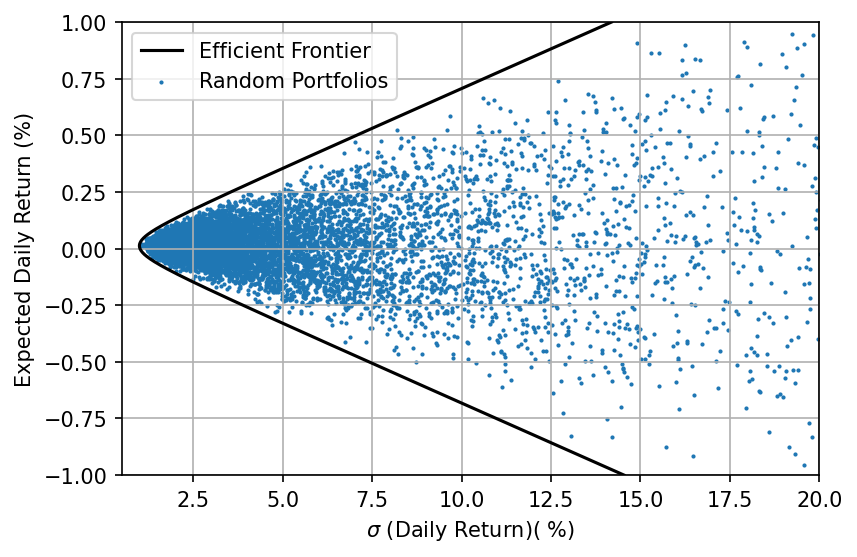

In [35]:
plt.figure(dpi = 150)
porfolios = np.random.rand(10000,len(df.columns))-.5
porfolios /= porfolios.sum(axis = 1)[:,np.newaxis]
dreturns = (df.diff()/df).values[1:]
preturns =(dreturns[:, np.newaxis, :] *porfolios[np.newaxis,:,:]).sum(axis =2)
pave = preturns.mean(axis = 0)
pvar =  preturns.std(axis = 0)
plt.scatter(100*pvar, 100*pave, s = 1, label = 'Random Portfolios')
x = np.r_[-1e-2:1e-2:500*1j]
variance = frontier(x, df)
plt.plot(100*variance**.5,x*100, color = 'black', label = 'Efficient Frontier')
plt.ylabel('Expected Daily Return (%)')
plt.xlabel(r'$\sigma$ (Daily Return)( %)')
plt.grid()
plt.ylim(-1, 1)
plt.xlim(.5, 20)
plt.legend()
Emin = x[np.argmin(variance)]
print(f'MVP return ={Emin*100:.3f}%, variance = {100*np.min(variance):.3f} %')

The majority of randomly chosen porfolios are close to zero return, implying a somewhat strong anticorrelation between portfolio values. 
Note that the portfolio values are allowed to be negative, which requires the ability to short sell options on the funds. 

In [53]:
desired_return = 1e-2
xk = (desired_return* (isigma @ (C*returns-A))  + (isigma @ (B - A*returns))) / D
(dreturns * xk).sum(axis = 1).mean(), (dreturns * xk).sum(axis = 1).std(),{ x:n for n,x in zip(xk, df.columns)}

(0.010000000199620709,
 0.14186382132757006,
 {'Apple.close': 1.8474962988314807,
  'Tesla.close': 1.7022706225387252,
  'Google.close': 4.715870245225443,
  'Walmart.close': -1.1236514654541352,
  'Citigroup.close': -1.9265270512098542,
  'Ford.close': -2.289150075730701,
  'Gold.close': -2.49852288186962,
  'GameStop.close': -0.6890176246335648,
  'Disney.close': -0.8930447434406252,
  'coke.close': 2.154276954898148})

In [48]:
df['etf'] = df.values[:, :-1] @ xk
print(xk.sum())

1.0000002791552967


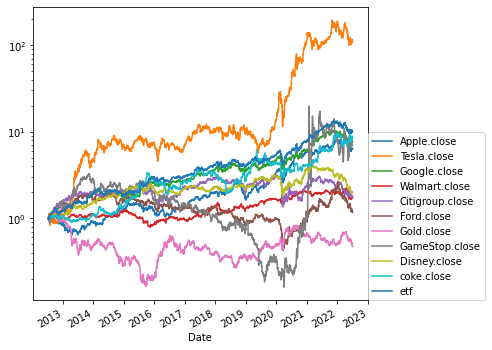

In [51]:
(df/df.iloc[0]).plot(figsize = (6,6))
plt.legend(loc = (1,0))
plt.gca().set_yscale('log')